# Reinforcement Learning for Ion Trap Quantum Computers

This exercise is a short extension of the two Tutorials: <br>
- **Ion Trap Reinforcement Learning Environment Tutorial** 
- **Projective Simulation Tutorial** 

Here we are going to employ the implemented Projective Simulation (PS) agent to use short laser pulse sequences mapping an initially unentangled state $|000\rangle$ onto a GHZ-like state:

\begin{align}
|\mathrm{GHZ}\rangle = \frac{1}{\sqrt{d}}\sum_{i=0}^{d-1}|iii\rangle.\nonumber
\end{align}

We will consider three qutrits, i.e., $d=3$ for simplicity but you may choose to extend this at your own leisure.

More formally, we do not want to find GHZ states exactly but those states which are maximally entangled. We consider $n$ $d$-level states to be maximally entangled if they have a *Schmidt rank vector* (SRV) of $(d,...,d)$ where the $i$th entry is the rank of the reduced density matrix $\rho_i=\mathrm{tr}_{\bar{i}}(\rho)$ where $\bar{i}$ is the complement of $\{i\}$ in $\{1,...,n\}$.

Luckily, you don't really have to take care of this since this is already the default settings of the environment which we are going to load now:

In [2]:
from ENV.IonTrap_env import IonTrapEnv

That was easy. According to the docs in the `init` method, the class allows the following kwargs:

* `num_ions` (int): The number of ions. Defaults to 3.
* `dim` (int): The local (odd) dimension of an ion. Defaults to 3.
* `goal` (list): List of SRVs that are rewarded. Defaults to `[[3,3,3]]`.
* `phases` (dict): The phases defining the laser gate set. Defaults to `{'pulse_angles': [np.pi/2], 'pulse_phases': [0, np.pi/2, np.pi/6], 'ms_phases': [-np.pi/2]}`
* `max_steps` (int): The maximum number of allowed time steps. Defaults to 10.

If you want to change anything you need to provide kwargs in form of a `dict` with the desired arguments as follows `IonTrapEnv(**{ 'max_steps': 20 })`. 
Indeed, let us submit a small change. Since this is just supposed to be a small scale test, let us reduce the number of allowed phases and therefore, the number of possible actions.

In [3]:
import numpy as np
KWARGS = {'phases': {'pulse_angles': [np.pi/2], 'pulse_phases': [np.pi/2], 'ms_phases': [-np.pi/2]}}
env = IonTrapEnv(**KWARGS)

Next, we need to get the PS agent and the ECM:

In [4]:
from PS.agent.Universal_Agent import UniversalAgent
from PS.ecm.Universal_ECM import UniversalECM

For the initialisation we read through the docs: <br>
Agent: <br>
* `ECM` (object): Episodic compositional memory (ECM). The brain of the agent.
* `actions` (np.ndarray): An array of possible actions. Specified by the environment.
* `adj_matrix` (np.ndarray): Adjancency matrix representing the structure of the default decision tree.

ECM: <br>
* `gamma_damping` (float): The damping (or gamma) parameter. Set to zero if the environment doesn't change in time. Defaults to 0.
* `eta_glow_damping` (float): glow parameter. Defaults to 0.1.
* `beta` (float): softmax parameter. Defaults to 1.


We don't know the actions and the adjancency matrix at this point, but want to keep all the other default parameters. Let's at first initialize the adjancency matrix. For now a two layered clip network is enough, later you can try other structures. I have a little task here.
<br>
<br>
__TASK:__ <br>
Initialize the adjancency matrix for the following decision tree. Use the PS Tutorial for help. <br>
Tipp: The size of the matrix is (number actions + 1, number actions + 1) <br>
<img src=images/tree_two_layer.png width="400"/>

__SOLUTION:__ <br>

In [8]:
num_actions = len(env.actions)

adj_matrix = np.zeros((num_actions + 1, num_actions + 1))
adj_matrix[0][list(range(1, num_actions + 1))] = 1

Now we can ask the environment what the actions are and initialize the agent accordingly:

In [9]:
actions = env.actions

ecm = UniversalECM()
agent = UniversalAgent(ECM=ecm, actions=actions, adj_matrix=adj_matrix)


Fantastic, we have everything ready for a first run. Let's do that. The interaction between an environment and an agent is standardized through the [*openAI* `gym`](https://github.com/openai/gym) environments. In terms of code, we can imagine the interaction to go as follows,

<img src=images/agent-env-code.png width="400"/>


Indeed, every reinforcement learning environment should provide at least two methods:

* `reset()`: Resets the environment to its initial state. *Returns* the initial observation.
* `step(action)`: Performs an action (given by an action index) on the environment. *Returns* the new observation, an associated reward and a bool value `done` which indicates whether a terminal state has been reached.

The agent on the other hand, supports the following two main methods:

* `predict(observation)` (here: `step(observation)`): Given an observation, the agent predicts an action. *Returns* an action index.
* `learn(reward)`: Uses the current reward to update internal network.

Knowing that the `IonTrapEnv` has been built according to this standard and the agent features the two methods above, we can start coding the interaction between agent and environment:

In [11]:
# data set for performance evaluation
DATA_STEPS = []
# maximum number of episodes
NUM_EPISODES = 500

for i in range(NUM_EPISODES):
    # initial observation from environment
    observation = env.reset()
    #bool: whether or not the environment has finished the episode
    done = False
    #int: the current time step in this episode
    num_steps = 0
    action_seq = []
    while not done:
        # increment counter
        num_steps += 1
        # predict action
        action = agent.step(observation)
        action_seq.append(action)
        # perform action on environment and receive observation and reward
        observation, reward, done = env.step(action)
        # learn from reward
        agent.learn(reward)
        
        # gather statistics
        if done:
            DATA_STEPS.append(num_steps)
    
print(action_seq)


[0, 4, 1, 0, 3, 5, 0]


And this is all the code that is needed to have an agent interact with our environment! In `DATA_STEPS` we have gathered the data that keeps track of the length of pulse sequences that generate GHZ-like states. We can use `matplotlib` to visualize the performance of the agent over time:

Text(0.5, 0, 'Episode')

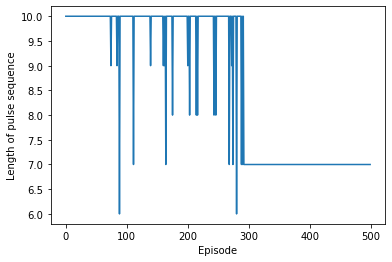

In [12]:
import matplotlib.pyplot as plt
import numpy as np

x_axis = np.arange(len(DATA_STEPS))

plt.plot(x_axis, DATA_STEPS)
plt.ylabel('Length of pulse sequence')
plt.xlabel('Episode')


We have witnessed an agent learning! The agent was able to push the gate sequences down to 5 laser pulses consisting of two Molmer-Sorensen gates and three single-ion laser pules.
Note that this is of course not conclusive because it is a single agent. Nevertheless, it has obviously learned and we can expect future agents to fare similarly. **Good work!**